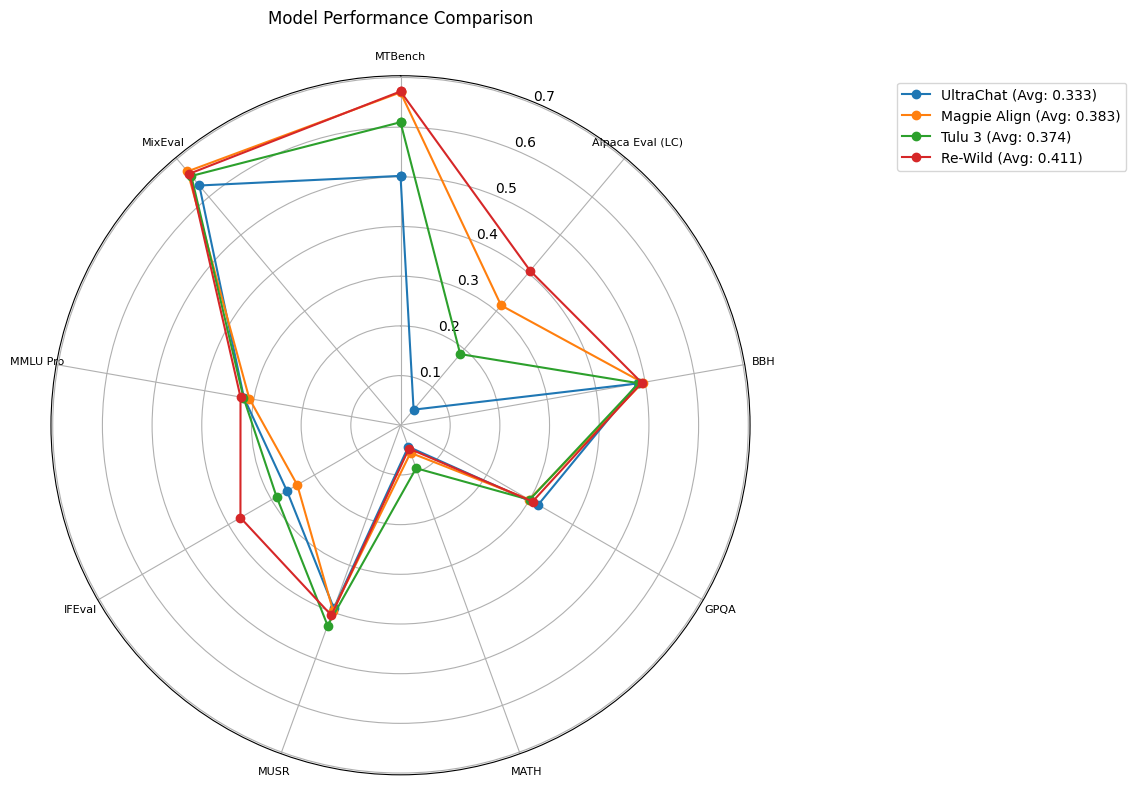

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('/content/rewild.csv')

# Get the feature names (excluding 'Model' and 'Average')
features = [col for col in df.columns if col not in ['Model', 'Average']]
num_features = len(features)

# Number of angles for the plot
angles = np.linspace(0, 2*np.pi, num_features, endpoint=False)

# Close the plot by appending the first value
angles = np.concatenate((angles, [angles[0]]))

# Create the figure and polar axis
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw=dict(projection='polar'))

# Plot data for each model
for idx, row in df.iterrows():
    values = [row[feature] for feature in features]
    # Close the plot by appending the first value
    values = np.concatenate((values, [values[0]]))

    # Create the plot with a label that includes the average
    label = f"{row['Model']} (Avg: {row['Average']:.3f})"
    ax.plot(angles, values, 'o-', linewidth=1.5, label=label)

# Fix axis to go in the right order and start at 12 o'clock
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw axis lines for each angle and label
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, size=8)

# Add legend
plt.legend(bbox_to_anchor=(1.2, 1.0), loc='upper left')

# Add title
plt.title('Model Performance Comparison', pad=20)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

## Multi Bar Plot

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file
df = pd.read_csv('scaling.csv')

# Create pivot table to reshape data for grouped bars
pivot_df = df.pivot(index='DGM', columns='Quantity(k)', values='Avg')

# Sort the index based on Quantity(k) values
pivot_df = pivot_df.reindex(df.groupby('DGM')['Quantity(k)'].mean().sort_values().index)

# Set the style
plt.style.use('seaborn-v0_8-paper')

# Create figure with appropriate size for single column
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Create grouped barplot
bar_width = 0.25
x = np.arange(len(pivot_df.index))

# Plot bars for each Quantity(k)
for i, col in enumerate(pivot_df.columns):
    ax.bar(x + i*bar_width, pivot_df[col],
           width=bar_width,
           label=f'{col}k')

# Customize the plot
ax.set_xticks(x + bar_width)
ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Avg')

# Set y-axis limits and ticks
ax.set_ylim(0.33, 0.38)
ax.set_yticks(np.arange(0.33, 0.38, 0.03))

# Add grid for better readability of values
ax.yaxis.grid(True, linestyle='--', alpha=0.7, zorder=0)

# Add legend
ax.legend(title='Quantity', bbox_to_anchor=(1.02, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the figure
plt.savefig('scaling_plot.pdf', bbox_inches='tight', dpi=300)
plt.savefig('scaling_plot.png', bbox_inches='tight', dpi=300)

## MT Bench Word Cloud

In [ ]:
!pip install -qq nltk wordcloud

In [ ]:
import pandas as pd
from collections import Counter
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from typing import Set, Optional, List

def setup_nltk():
    """
    Download required NLTK resources
    """
    try:
        nltk.data.find('tokenizers/punkt')
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('punkt')
        nltk.download('averaged_perceptron_tagger')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt_tab')
    nltk.download('averaged_perceptron_tagger_eng')

def load_and_process_csv(file_path):
    """
    Load CSV file into a pandas DataFrame

    Args:
        file_path (str): Path to the CSV file

    Returns:
        pd.DataFrame: Loaded DataFrame
    """
    return pd.read_csv(file_path)

def get_words_from_text(text: str,
                       target_words: Optional[List[str]] = None,
                       remove_punctuation: bool = True,
                       lowercase: bool = True) -> Set[str]:
    """
    Extract unique words (adjectives and specified target words) from text

    Args:
        text (str): Input text
        target_words (List[str], optional): List of specific words to look for
        remove_punctuation (bool): Whether to remove punctuation
        lowercase (bool): Whether to convert text to lowercase

    Returns:
        set: Set of unique words (adjectives and target words)
    """
    if lowercase:
        text = text.lower()
        if target_words:
            target_words = [word.lower() for word in target_words]

    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize and get POS tags
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)

    # Extract adjectives (JJ, JJR, JJS tags)
    words = {word for word, tag in pos_tags if tag.startswith('JJ')}

    # Add any target words that appear in the text
    if target_words:
        text_tokens = set(tokens)
        target_words_found = {word for word in target_words if word in text_tokens}
        words.update(target_words_found)

    return words

def get_word_frequencies(df: pd.DataFrame,
                        column_name: str,
                        target_words: Optional[List[str]] = None,
                        remove_punctuation: bool = True,
                        lowercase: bool = True) -> Counter:
    """
    Calculate frequencies for adjectives and target words,
    counting each word only once per row

    Args:
        df (pd.DataFrame): Input DataFrame
        column_name (str): Name of the column to analyze
        target_words (List[str], optional): List of specific words to look for
        remove_punctuation (bool): Whether to remove punctuation
        lowercase (bool): Whether to convert text to lowercase

    Returns:
        Counter: Word frequency counts
    """
    all_words = []

    for text in df[column_name].astype(str):
        # Get unique words from this row
        row_words = get_words_from_text(
            text,
            target_words=target_words,
            remove_punctuation=remove_punctuation,
            lowercase=lowercase
        )
        all_words.extend(row_words)

    return Counter(all_words)

def display_top_words(counter: Counter, n: int = 10):
    """
    Display the top N most frequent words
    """
    print(f"\nTop {n} most frequent words:")
    for word, count in counter.most_common(n):
        print(f"{word}: {count}")

def create_wordcloud(counter, title="Adjective Word Cloud",
                    width=800, height=400, background_color='white'):
    """
    Create and display a word cloud from adjective frequencies
    """
    # Create a modified counter for better word cloud display
    display_counter = Counter()
    for word, count in counter.items():
        if word.startswith('not-'):
            # Replace hyphen with space for better display
            display_counter[f"not {word[4:]}"] = count
        else:
            display_counter[word] = count

    # Create and generate word cloud
    wordcloud = WordCloud(
        width=width,
        height=height,
        background_color=background_color,
        min_font_size=10,
        max_font_size=150,
        collocations=False  # Prevent splitting of "not adjective"
    ).generate_from_frequencies(dict(display_counter))

    # Display the word cloud
    plt.figure(figsize=(width/100, height/100))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [ ]:
setup_nltk()

In [ ]:
file_path = '/content/combined_preferences.csv'

df = load_and_process_csv(file_path)

# Define target words to look for in addition to adjectives
target_words = ["lacks", "fails", "missing", "struggles"]

# Get word frequencies for the 'judgment_qwen' column
qwen_freqs = get_word_frequencies(
    df,
    'judgment_qwen',
    target_words=target_words
)

# Display top 10 most frequent adjectives
display_top_words(qwen_freqs, n=30)

In [ ]:
create_wordcloud(qwen_freqs, title="Key Words in Qwen Judgments")